In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import anndata
import networkx as nx
import scanpy as sc
from anndata import AnnData
from typing import Any, List, Mapping, Optional
import pandas as pd
import numpy as np
import seaborn as sns

from src.config import configure_dataset

rna = anndata.read_h5ad("./data/rna_hvg.h5ad")
atac = anndata.read_h5ad("./data/atac_hvg.h5ad")
graph = nx.read_graphml("./data/guidance-hvf.graphml.gz")

rna.obsm['X_pre'] = rna.X
atac.obsm['X_pre'] = atac.X

print(rna)
print(atac)
# rna.X=rna.layers['counts']
print(graph)

AnnData object with n_obs × n_vars = 9631 × 2000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_pre'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 9631 × 13205
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCo

In [3]:
adatas=[rna, atac]
modal_names=["RNA", "ATAC"]
prob=['Normal','Normal']
rep = ['X_pre', 'X_pre']
cell_type = ['cell_type', 'cell_type']
save_path = "./ckpt"

In [ ]:
from src.train import covel_train

vertices = sorted(graph.nodes)
for idx, adata in enumerate(adatas):
    configure_dataset(adata, prob[idx], 
                      use_highly_variable=True,
                      use_rep=rep[idx],
                      use_cell_type=cell_type[idx])

data = dict(zip(modal_names, adatas))

covel = covel_train(
        data, 
        graph,
        fit_kws={"directory": save_path, "max_epochs":40}
)

In [ ]:
print("Integration data")
for modal_name in modal_names:
    data[modal_name].obsm['embedding'] = covel.encode_data(modal_name, data[modal_name])
    
combined = anndata.AnnData(
        obs=pd.concat([adata.obs for adata in adatas], join="inner"),
        obsm={"embedding": np.concatenate([
            adata.obsm["embedding"] for adata in adatas
        ])}
)

combined.obs["domain"] = pd.Categorical(
        combined.obs["domain"],
        # categories=modal_names
)

combined.uns["domain_colors"] = list(sns.color_palette(n_colors=len(modal_names)).as_hex())

feature_embeddings = covel.encode_graph(graph)
feature_embeddings = pd.DataFrame(feature_embeddings, index=covel.vertices)

for adata in adatas:
    adata.varm["embedding"] = feature_embeddings.reindex(adata.var_names).to_numpy()

In [ ]:
print("UMAP vis integration data, in combined.h5ad X_umap")
sc.pp.neighbors(combined, 
                # n_pcs=10, 
                use_rep="embedding", metric="cosine")
sc.tl.umap(combined)

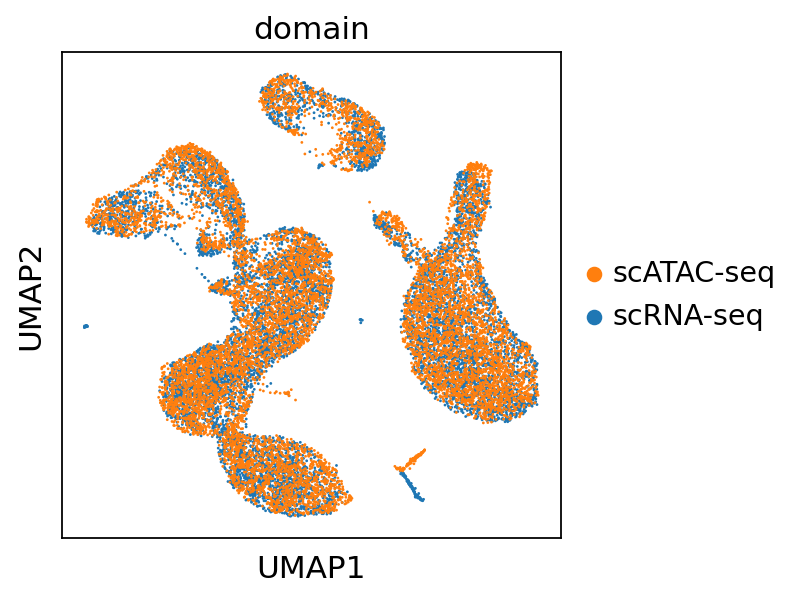

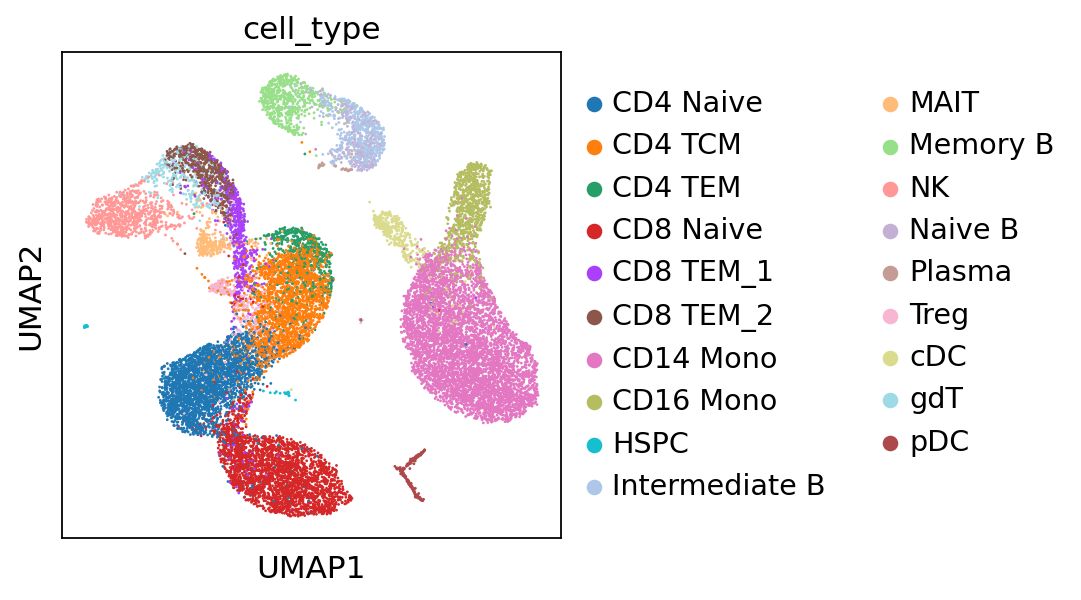

In [8]:
sc.set_figure_params(dpi=80)

combined.uns["domain_colors"] = list(sns.color_palette(n_colors=len(modal_names)).as_hex())[::-1]

sc.pl.umap(combined, color=['domain'])
sc.pl.umap(combined, color=['cell_type'])

In [ ]:
from src.metrics import graph_connectivity, avg_silhouette_width

gc = graph_connectivity(combined.obsm['embedding'], np.array(combined.obs['cell_type']))
print("gc: ", gc)
avg = avg_silhouette_width(combined.obsm['embedding'], np.array(combined.obs['cell_type']))
print("avg: ", avg)